In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np, pandas as pd, pickle, time, argparse
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data preprocessing

In [2]:
import neattext.functions as nfx

def read_glove_vecs(glove_file: str) -> tuple:
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}

        for line in f:
            line = line.strip().split()
            current_word = line[0]
            words.add(current_word)
            word_to_vec_map[current_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index, index_to_words = {}, {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i += 1

    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def preprocess_text(text:str)->str:
    text = text.lower()
    text = nfx.remove_punctuations(text)
    text = nfx.remove_stopwords(text)
    text = ' '.join(text.split())

    return text

def create_utterances(filename:str, split: str):
    sentences, act_labels, emotion_labels, speakers, conv_id, utt_id = [], [], [], [], [], []

    with open(filename, 'r') as f:
        for c_id, line in enumerate(f):
            s = eval(line)
            for u_id, item in enumerate(s['dialogue']):
                sentences.append(item['text'])
                act_labels.append(item['act'])
                emotion_labels.append(item['emotion'])
                conv_id.append(split[:2] + "_c" + str(c_id))
                utt_id.append(split[:2] + "_c" + str(c_id) + "_u" + str(u_id))
                speakers.append(str(u_id%2))

    data = pd.DataFrame(sentences, columns=['sentence'])
    data['sentence'] = data['sentence'].apply(lambda x: preprocess_text(x))
    data['act_label'] = act_labels
    data['emotion_label'] = emotion_labels
    data['speaker'] = speakers
    data['conv_id'] = conv_id
    data['utt_id'] = utt_id

    return data

In [3]:
# Generate datasets
DAILYDIALOG_DIR_PATH = "../data/dailydialog/"

train_data = create_utterances(DAILYDIALOG_DIR_PATH + 'train.json', 'train')
valid_data = create_utterances(DAILYDIALOG_DIR_PATH + 'valid.json', 'valid')
test_data = create_utterances(DAILYDIALOG_DIR_PATH + 'test.json', 'test')

In [4]:
# Encode emotion and dialog act labels
def encode_labels(encoder, l):
    return encoder[l]

all_act_labels, all_emotion_labels = set(train_data["act_label"]), set(train_data["emotion_label"])
act_label_encoder, emotion_label_encoder, act_label_decoder, emotion_label_decoder = {}, {}, {}, {}

for i, label in enumerate(all_act_labels):
    act_label_encoder[label] = i
    act_label_decoder[i] = label

for i, label in enumerate(all_emotion_labels):
    emotion_label_encoder[label] = i
    emotion_label_decoder[i] = {}

train_data['encoded_act_label'] = train_data['act_label'].map(lambda x: encode_labels(act_label_encoder, x))
test_data['encoded_act_label'] = test_data['act_label'].map(lambda x: encode_labels(act_label_encoder, x))
valid_data['encoded_act_label'] = valid_data['act_label'].map(lambda x: encode_labels(act_label_encoder, x))

train_data['encoded_emotion_label'] = train_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
test_data['encoded_emotion_label'] = test_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
valid_data['encoded_emotion_label'] = valid_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))

In [5]:
# Tokenize all sentences
all_text = list(train_data['sentence'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)

In [6]:
# Convert sentences into sequences
train_sequence = tokenizer.texts_to_sequences(list(train_data['sentence']))
valid_sequence = tokenizer.texts_to_sequences(list(valid_data['sentence']))
test_sequence = tokenizer.texts_to_sequences(list(test_data['sentence']))

train_data['sentence_length'] = [len(item) for item in train_sequence]
valid_data['sentence_length'] = [len(item) for item in valid_sequence]
test_data['sentence_length'] = [len(item) for item in test_sequence]

MAX_NUM_TOKENS = 250

train_sequence = pad_sequences(train_sequence, maxlen=MAX_NUM_TOKENS, padding='post')
valid_sequence = pad_sequences(valid_sequence, maxlen=MAX_NUM_TOKENS, padding='post')
test_sequence = pad_sequences(test_sequence, maxlen=MAX_NUM_TOKENS, padding='post')

train_data['sequence'] = list(train_sequence)
valid_data['sequence'] = list(valid_sequence)
test_data['sequence'] = list(test_sequence)

# Define the Neural Network with Pre-trained Embedding Layer

In [7]:
class Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, vocab_size, ouput_dim, batch_size) -> None:
        super(Net, self).__init__()

        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.word_embeddings = embedding
        self.vocab_size = vocab_size

        # LSTM takes word embeddings as inputs and outputs hidden states with dimensionality hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout=0.5, batch_first=True)

        # Fully-connected linear layer
        self.fc = nn.Linear(hidden_dim, ouput_dim)

    
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)

        # Initialise hidden state
        h0 = torch.zeros(2, sentence.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(2, sentence.size(0), self.hidden_dim).requires_grad_().to(device)

        lstm_out, h = self.lstm(embeds, (h0, c0))
        lstm_out = lstm_out[:, -1, :]

        # Dropout
        lstm_out = F.dropout(lstm_out, 0.5)

        fc_out = self.fc(lstm_out)

        out = F.softmax(fc_out, dim=1)
        return out

# Create GloVe Embedding Layer

In [8]:
from random import sample

def pretrained_embedding_layer(word_to_vec_map: dict, word_to_index: dict, non_trainable: bool=True) -> tuple:
    num_embeddings = len(word_to_index) + 1
    random_word = sample(word_to_vec_map.keys(), 1)[0]
    embedding_dim = word_to_vec_map[random_word].shape[0]
    
    # Initialise embedding matrix as a numpy array of zeroes of shape num_embeddings * embedding_dim
    weights_matrix = np.zeros((num_embeddings, embedding_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation 
    # of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        weights_matrix[index, :] = word_to_vec_map[word]
        
    embed = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).type(torch.FloatTensor), freeze=non_trainable)

    return embed, num_embeddings, embedding_dim

# Train the model

In [9]:
# Extract sequences
X_train = train_data['sequence'] #.to_numpy()
X_test = test_data['sequence'] #.to_numpy()
X_valid = valid_data['sequence'] #.to_numpy()

y_train = train_data['encoded_emotion_label'].to_numpy()
y_test = test_data['encoded_emotion_label'].to_numpy()
y_valid = valid_data['encoded_emotion_label'].to_numpy()

# Convert emotion labels to one-hot vectors
C = train_data['encoded_emotion_label'].value_counts().size
y_oh_train = convert_to_one_hot(y_train, C)
y_oh_test = convert_to_one_hot(y_test, C)
y_oh_valid = convert_to_one_hot(y_valid, C)

In [10]:
# Load GloVe model
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../glove_model/glove.6B.100d.txt')

In [11]:
embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index)

<ipython-input-8-07bd32ff251b>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_word = sample(word_to_vec_map.keys(), 1)[0]


In [12]:
HIDDEN_DIM = 128
OUTPUT_SIZE = 7
BATCH_SIZE = 32
EPOCHS = 3

In [13]:
# Generate dataloaders
train_dataset = TensorDataset(torch.Tensor(X_train).type(torch.LongTensor), torch.tensor(y_train).type(torch.LongTensor))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.Tensor(X_test).type(torch.LongTensor), torch.tensor(y_test).type(torch.LongTensor))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(torch.Tensor(X_valid).type(torch.LongTensor), torch.tensor(y_valid).type(torch.LongTensor))
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

<ipython-input-13-fa55b7cc28fd>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_dataset = TensorDataset(torch.Tensor(X_train).type(torch.LongTensor), torch.tensor(y_train).type(torch.LongTensor))


In [14]:
from tqdm import tqdm

def train(model, trainloader, criterion, optimizer, epochs=10):
    model.to(device)
    running_loss = 0
    train_losses, test_losses, accuracies = [], [], []
    for e in range(epochs):
        model.train()
        running_loss = 0
        for sentences, labels in tqdm(trainloader, f"EPOCH {e + 1}"):
            sentences, labels = sentences.to(device), labels.to(device)
            optimizer.zero_grad() # Erase previous gradients
            pred = model.forward(sentences) # Make a prediction
            loss = criterion(pred, labels) # Calculate how much we missed
            loss.backward()
            optimizer.step()
            running_loss += loss.item() # Log our progress

        else:
            model.eval()

            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                for sentences, labels in test_loader:
                    sentences, labels = sentences.to(device), labels.to(device)
                    log_ps = model(sentences)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(test_loader))
            accuracies.append(accuracy / len(test_loader) * 100)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

            

    # Plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_losses, c='b', label='Training loss')
    plt.plot(test_losses, c='r', label='Testing loss')
    plt.xticks(np.arange(0, epochs))
    plt.title('Losses')
    plt.legend(loc='upper right')
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(accuracies)
    plt.xticks(np.arange(0, epochs))
    plt.title('Accuracy')
    plt.show()

In [15]:
# import time
# from tqdm import tqdm

# def train(dataloader):
#     model.train()
#     # total_acc, total_count = 0, 0
#     # log_interval = 50
#     # start_time = time.time()

#     for sentences, labels in tqdm(dataloader, "Training in progress..."):
#         sentences, labels = sentences.to(device), labels.to(device)
#         optimizer.zero_grad() # Erase previous gradients
#         pred = model.forward(sentences) # Make a prediction
#         loss = criterion(pred, labels) # Calculate how much we missed
#         loss.backward()
#         optimizer.step()

#         # log_ps = model(sentences)
#         # # loss = criterion(log_ps, labels)

#         # ps = torch.exp(log_ps)
#         # top_p, top_class = ps.topk(1, dim=1)
#         # equals = top_class == labels.view(*top_class.shape)
#         # total_acc += torch.mean(equals.type(torch.FloatTensor))
#         # total_count += label.size(0)
#         # if idx % log_interval == 0 and idx > 0:
#         #     elapsed = time.time() - start_time
#         #     print('| epoch {:3d} | {:5d}/{:5d} batches '
#         #           '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
#         #                                       total_acc/total_count))
#         #     total_acc, total_count = 0, 0
#         #     start_time = time.time()

# def evaluate(dataloader):
#     model.eval()
#     total_acc, total_count = 0, 0

#     with torch.no_grad():
#         for sentences, labels in tqdm(dataloader, "Evaluating model..."):
#             # pred = model(sentences)
#             # loss = criterion(pred, label)
#             # total_acc += (pred.argmax(1) == label).sum().item()
#             # total_count += label.size(0)
#             log_ps = model(sentences)
#             # loss = criterion(log_ps, labels)

#             ps = torch.exp(log_ps)
#             top_p, top_class = ps.topk(1, dim=1)
#             equals = top_class == labels.view(*top_class.shape)
#             total_acc += torch.mean(equals.type(torch.FloatTensor))
#             total_count += labels.size(0)

#     return total_acc/total_count

EPOCH 1: 100%|██████████| 2725/2725 [19:18<00:00,  2.35it/s]


Epoch: 1/3..  Training Loss: 1.340..  Test Loss: 1.349..  Test Accuracy: 0.817


EPOCH 2: 100%|██████████| 2725/2725 [22:34<00:00,  2.01it/s]


Epoch: 2/3..  Training Loss: 1.338..  Test Loss: 1.349..  Test Accuracy: 0.817


EPOCH 3: 100%|██████████| 2725/2725 [14:49<00:00,  3.06it/s]


Epoch: 3/3..  Training Loss: 1.338..  Test Loss: 1.349..  Test Accuracy: 0.817


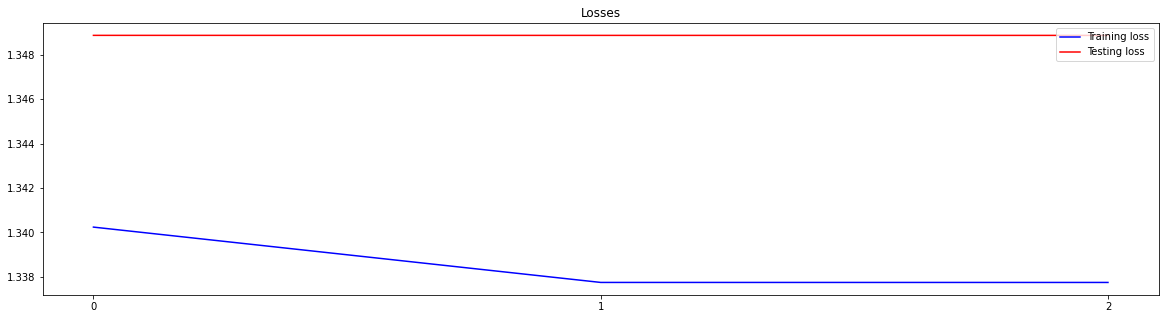

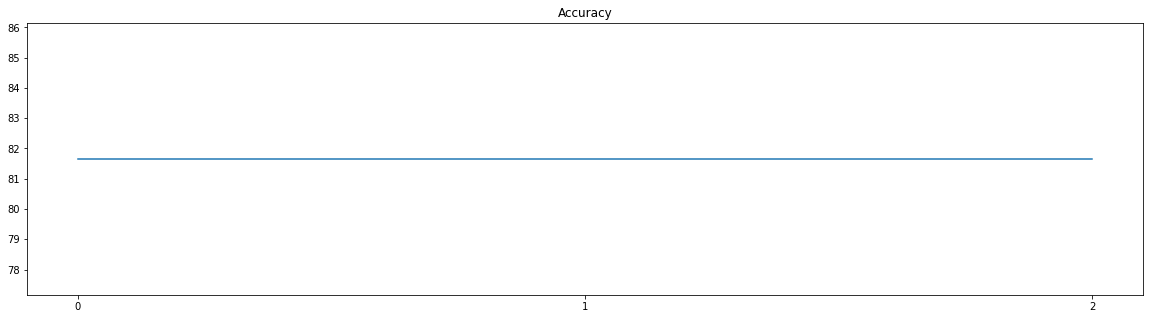

In [16]:
# Training time!
model = Net(embedding, embedding_dim, HIDDEN_DIM, vocab_size, OUTPUT_SIZE, BATCH_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
total_accu = None
train(model, train_loader, criterion, optimizer, EPOCHS)
# N = 10
# acc = 0
# epoch_counter = 0

# for epoch in range(1, EPOCHS + 1):
#     epoch_start_time = time.time()
#     train(train_loader)
    
#     # Question 5: Use your validation set to early stop the model. Remember to early stop when the validation accuracy does not improve for continous N number of epochs where N is a hyperparameter. Set N = 10
#     val_acc = evaluate(valid_loader)
#     if (acc >= val_acc):
#         epoch_counter += 1
#         if (epoch_counter == N): 
#             print("Validation set accuracy = " + str(val_acc) + "%")
#             break
#     else:
#         acc = val_acc
#         epoch_counter = 0

In [17]:
# Test model accuracy

test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for sentences, labels in test_loader:
        sentences, labels = sentences.to(device), labels.to(device)
        ps = model(sentences)
        test_loss += criterion(ps, labels).item()

        # Accuracy
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
model.train()
print("Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
running_loss = 0

Test Loss: 1.349..  Test Accuracy: 0.817
